# Decision Tree Regressors

**Aim of analysis**: to create a predictive model of carbon for seagrass beds using regression ML methods

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#from sklearn.ensemble import 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import scipy.stats as stats
from sklearn.metrics import mean_squared_error as MSE
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import PredictionErrorDisplay
import graphviz

## 1. Import Data

Imported dataset is pre-processed from linear regression analysis

In [4]:
#imported dataframe is already preprocessed and encoded
df_import = pd.read_csv('outputs/preprocessed_df.csv', index_col = 0)

Quick visualisation of correlations....correlating variables were removed in previous pre-processing

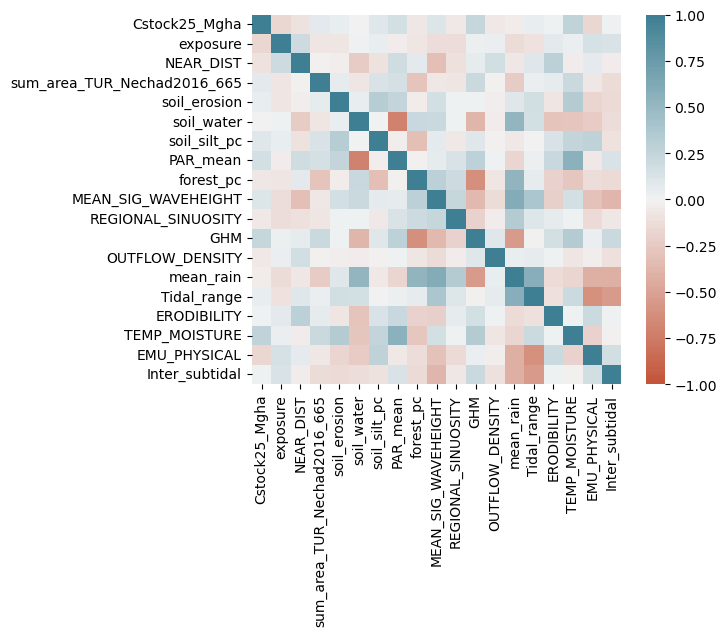

In [7]:
sns.heatmap(
    df_import.corr(),
    vmin = -1, vmax = 1, center = 0, 
    cmap = sns.diverging_palette(20, 220, n= 200),
    square = True
);

Quick pairplot of all the variables to visualise - it's big!

C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


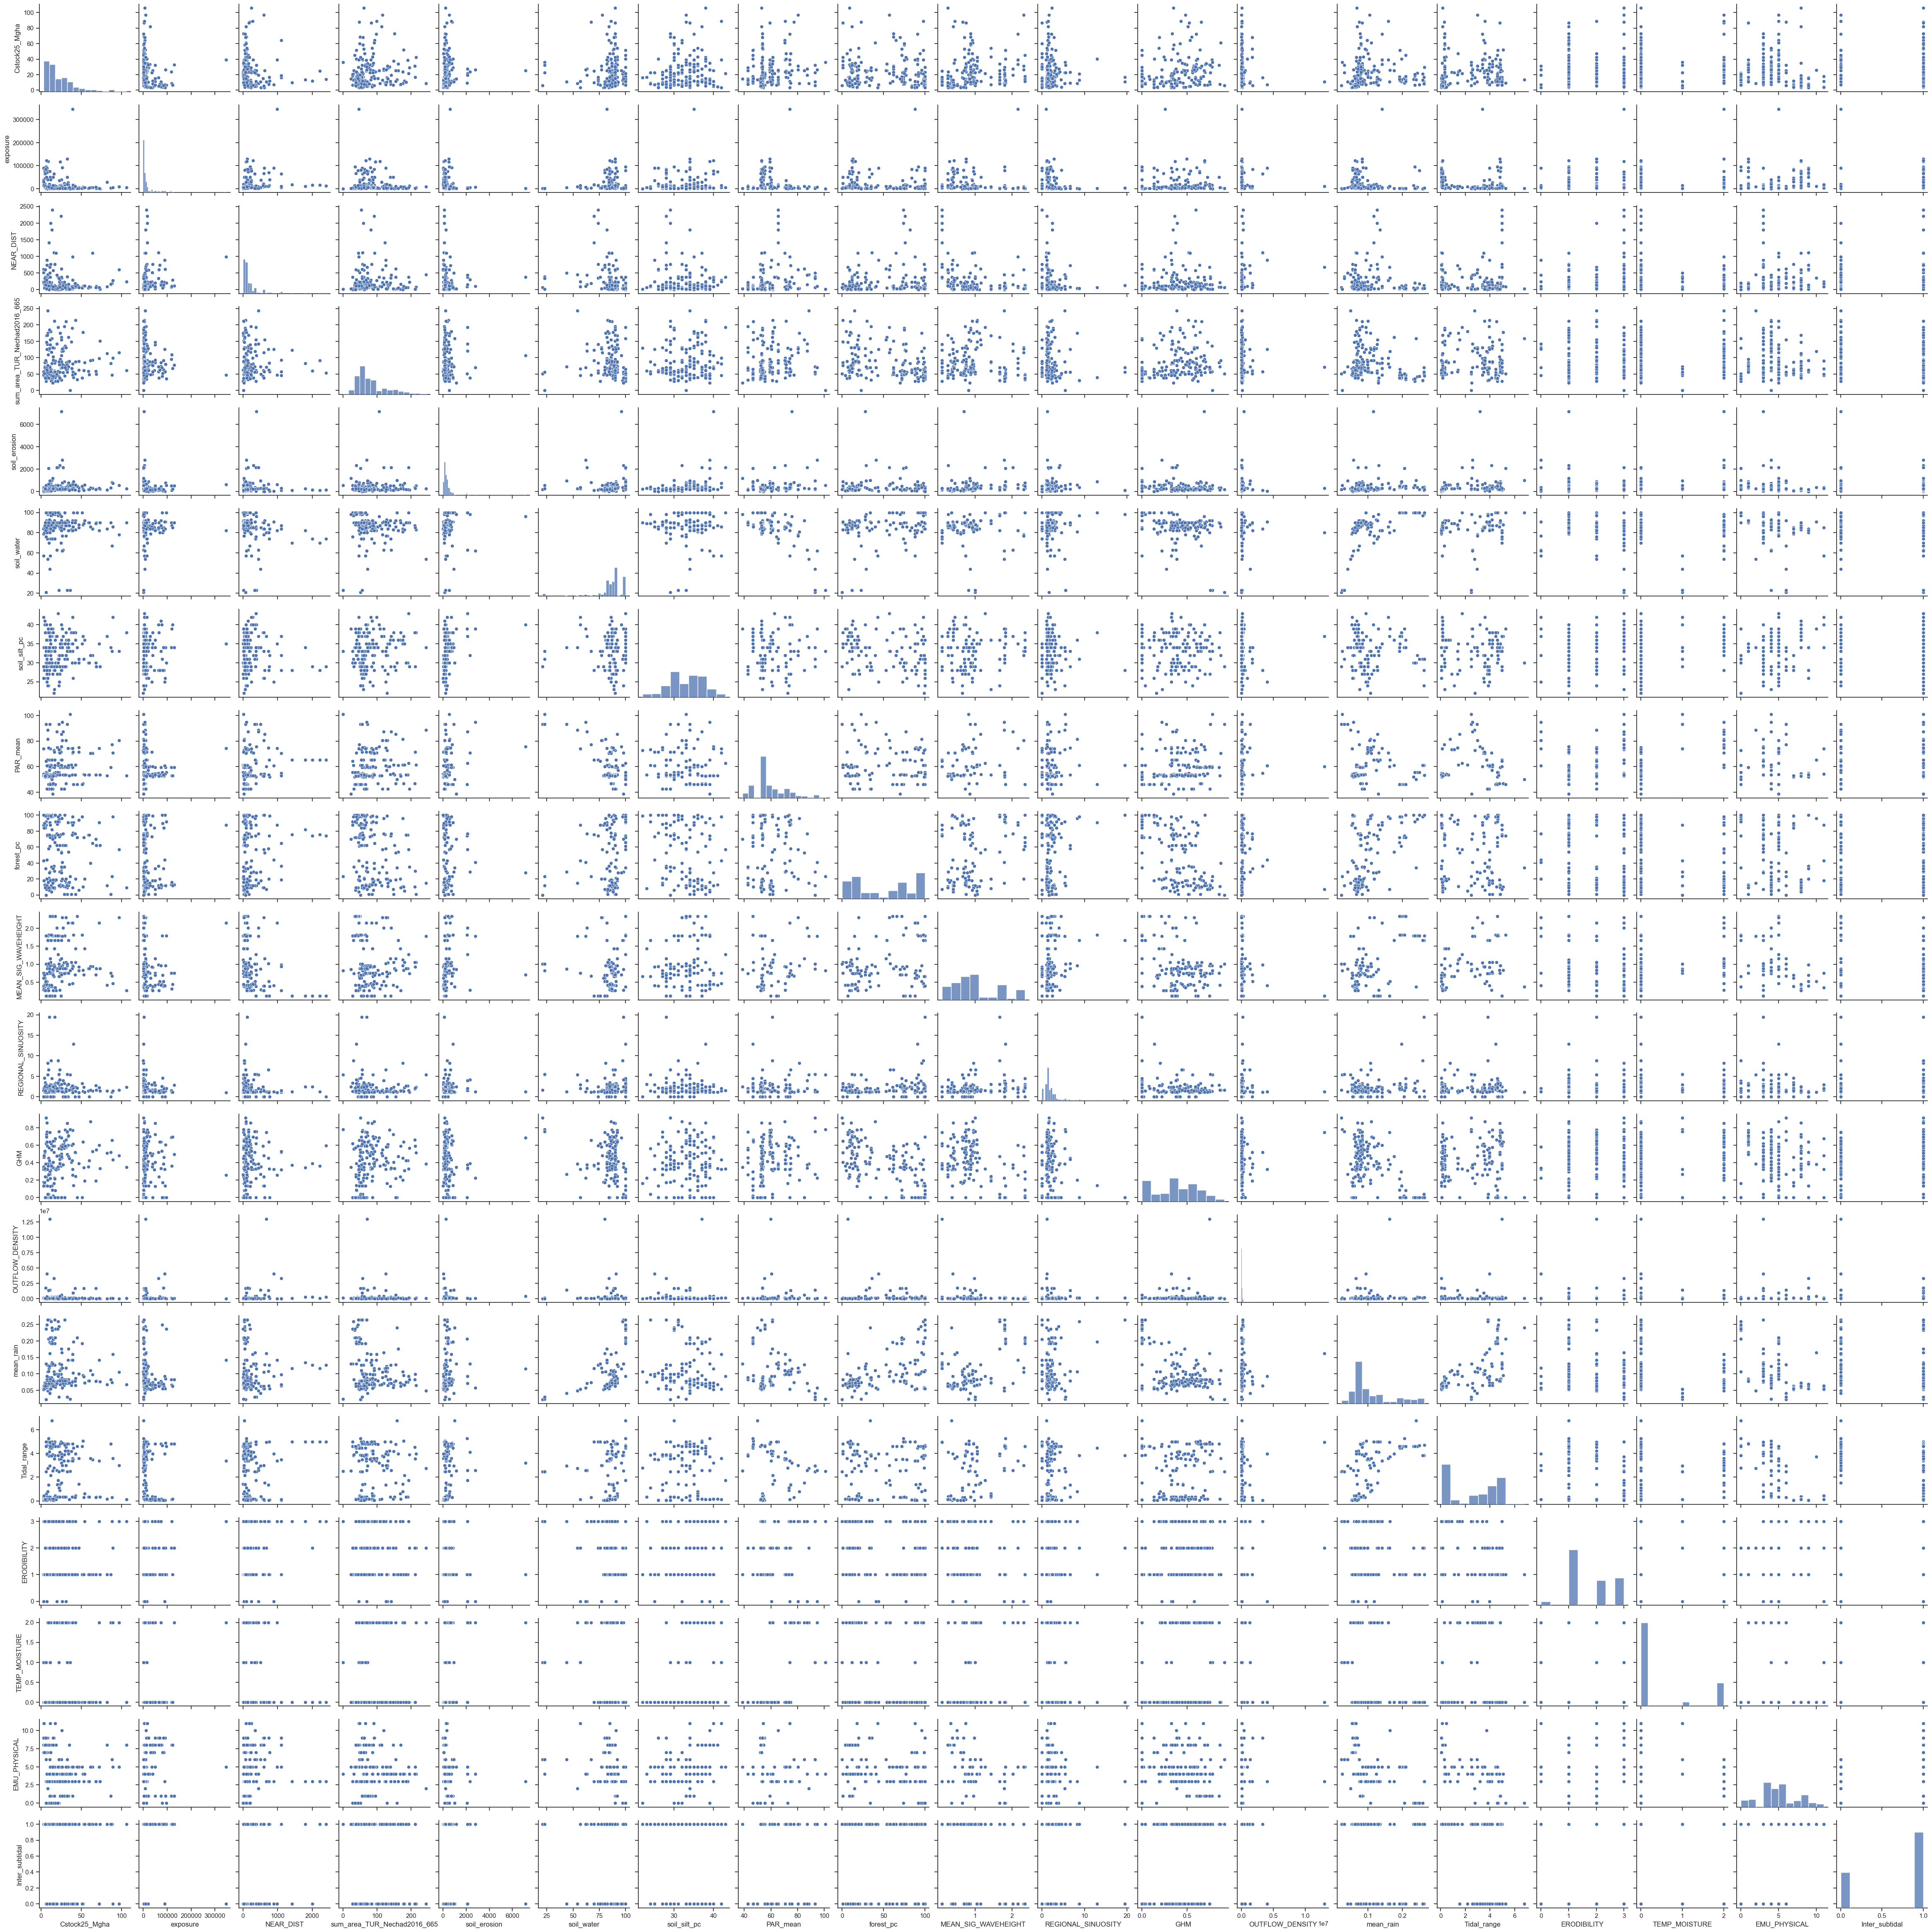

In [64]:
sns.pairplot(df_import);

## 2. Split into test and train datasets
Dataset is shuffled, split into X and y, y is logged to create balance across the dataset as carbon distribution is heavily skewed and finally rounded to one decimal place. The dataset is split into test_train set for cross validation (train) and test set for validation. 

In [71]:
# # #find any rows in continuous predictor variables with 0 value and remove them from dataset to check if causing problems
# cont_pred = ['exposure', 'NEAR_DIST', 'sum_area_TUR_Nechad2016_665',
#        'soil_erosion', 'soil_water', 'soil_silt_pc', 'PAR_mean', 'forest_pc',
#        'MEAN_SIG_WAVEHEIGHT', 'REGIONAL_SINUOSITY', 'GHM', 'OUTFLOW_DENSITY',
#        'mean_rain']  #continuous predictor variables
# df_cont = df_import.loc[:, cont_pred]
# check_rows = df_cont[(df_cont == 0).any(axis=1)].index  
#df = df_import.drop(check_rows)
df = df_import.copy()
# lev_ids = ['ID_234', 'ID_254', 'ID_272', 'ID_279']
# df = df.drop(lev_ids)

df = df.sample(frac=1, random_state=0)  #shuffle whole dataset (as gridsearch does not shuffle)

X = df.drop(['Cstock25_Mgha'], axis = 1)
y = df.loc[:, 'Cstock25_Mgha']
X.shape

(175, 18)

In [73]:
#log continuous variables only and re merge with rest of dataframe

# X_log_cont = np.log(X[cont_pred])
# X_other = X.loc[:, X.columns.difference(cont_pred)].copy() #copy all the other columns across to merge together
# X_log = pd.concat([X_log_cont, X_other], axis =1) #merge back together the logged columns and the non-logged columns

#log y
y_log = np.log(y)
y_log = round(y_log,1)

In [74]:
print('X shape: ', X.shape)
print('y shape: ', y_log.shape)

X shape:  (175, 18)
y shape:  (175,)


In [75]:
#split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size = 0.15, shuffle = True)

print('X train shape: ', X_train.shape)
print('X test shape: ', X_test.shape)

X train shape:  (148, 18)
X test shape:  (27, 18)


In [76]:
#create eval set for early stopping analysis
eval_set = [(X_train, y_train),(X_test, y_test)]

## 3. Perform Grid Search to find best hyper-parameters

Perform CV Grid Search on multiple regressors and save out best model

In [38]:
#Perform CV Grid Search on multiple regressors and save out best model

models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state =42),
    'RandomForestRegressor': RandomForestRegressor(random_state = 42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state = 42), 
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state = 42),
    'XGBoost': xgb.XGBRegressor(booster="gbtree", random_state = 42),
}

param_grids = {
    'DecisionTreeRegressor': { 'max_depth': [2,3,4], 
                              'min_samples_leaf':[10,12,15,18],
                              'max_features': ['log2', 'sqrt'] },
    'RandomForestRegressor': { 'n_estimators': [16,21,32,100],
                              'min_samples_split':[10,12,14],
                              'max_features': ['log2', 'sqrt'],
                             'max_depth': [2,3,4] },
    'HistGradientBoosting': { 'min_samples_leaf':[15,20,30,32],
                             'max_depth': [2,3],
                            'max_iter': [75,100,200]},  #The maximum number of iterations of the boosting process, i.e. the maximum number of trees.
    'GradientBoostingRegressor': {'n_estimators': [20, 32, 50, 100],
                                  'max_depth': [2,3,4],
                                  'min_samples_split': [10,12,14,],
                                  #'min_samples_leaf': [10,8,6],
                                   'max_features': [25,'log2', 'sqrt'],
                                 'subsample':[0.7,0.8,0.9],
                                 },
    'XGBoost': {'learning_rate': [0.1],
                'n_estimators': [24],
                #'subsample': [0.2,0.3,1],
                'max_depth' : [2,3,4],
                'colsample_bytree' : [0.3,0.4], #smaller creates better spread on actual vs predicted
                'reg_lambda': [0.15],
                'min_child_weight': [0,0.5],
                'gamma': [0.1,0.2]
                },
               }


cv = KFold(n_splits=3, shuffle=True, random_state=42)

results = []
best_models = []
best_params = []
for name, model in models.items():
    print(name)
    #print(model)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        scoring = 'neg_mean_squared_error',
        cv=cv,
    ).fit(X_train, y_train)


    best_model = {"model":name, "best_model": grid_search.best_estimator_}
    best_models.append(best_model)
    best_param = {"model":name, "best_param": grid_search.best_params_}
    best_params.append(best_param)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

DecisionTreeRegressor
RandomForestRegressor
HistGradientBoosting
GradientBoostingRegressor
XGBoost


In [65]:
#print out best params for XGBoost
print('Best params for XGBoost model: ', best_params[4])

Best params for XGBoost model:  {'model': 'XGBoost', 'best_param': {'colsample_bytree': 0.3, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 24, 'reg_lambda': 0.15}}


## Early Stopping

Check if early stopping helps using XGBoost best params....result = stop before 25 estimators

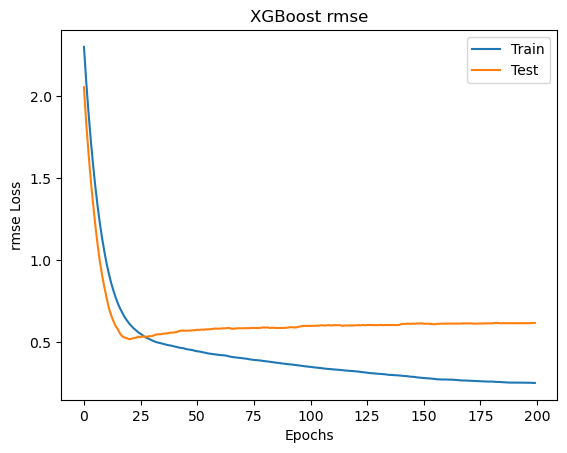

In [22]:
xgb_model = xgb.XGBRegressor(booster='gbtree', 
              colsample_bytree=0.4, 
              gamma = 0.1, 
              learning_rate=0.1, max_depth=2,
              min_child_weight=0, n_estimators=200, reg_lambda = 0.15, eval_metric = "rmse")

xgb_model.fit(X_train, y_train,  eval_set = eval_set, verbose = False)

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse Loss')
plt.xlabel('Epochs')
plt.title('XGBoost rmse')
plt.show()

[0]	validation_0-rmse:2.30094	validation_1-rmse:2.05494
[1]	validation_0-rmse:2.09094	validation_1-rmse:1.83871
[2]	validation_0-rmse:1.90316	validation_1-rmse:1.65625
[3]	validation_0-rmse:1.73506	validation_1-rmse:1.49036
[4]	validation_0-rmse:1.58693	validation_1-rmse:1.34880
[5]	validation_0-rmse:1.45250	validation_1-rmse:1.21626
[6]	validation_0-rmse:1.33358	validation_1-rmse:1.09725
[7]	validation_0-rmse:1.22861	validation_1-rmse:0.99468
[8]	validation_0-rmse:1.13560	validation_1-rmse:0.91024
[9]	validation_0-rmse:1.05421	validation_1-rmse:0.83667
[10]	validation_0-rmse:0.98045	validation_1-rmse:0.77029
[11]	validation_0-rmse:0.91829	validation_1-rmse:0.70928
[12]	validation_0-rmse:0.86249	validation_1-rmse:0.66454
[13]	validation_0-rmse:0.81506	validation_1-rmse:0.62868
[14]	validation_0-rmse:0.77327	validation_1-rmse:0.59984
[15]	validation_0-rmse:0.73571	validation_1-rmse:0.57797
[16]	validation_0-rmse:0.70469	validation_1-rmse:0.55136
[17]	validation_0-rmse:0.67799	validation

C:\Users\nw431\Miniconda3\envs\sklearn\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


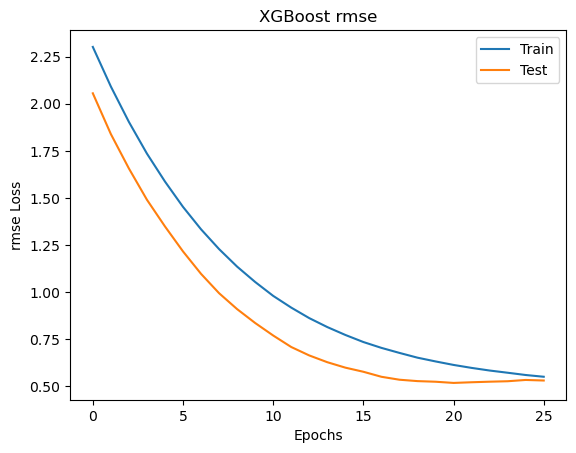

In [25]:
#refit and predict
xgb_model.fit(X_train, y_train, early_stopping_rounds = 5, eval_set = eval_set)
y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]
score = r2_score(y_test, predictions)
#print('r2', score)

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse Loss')
plt.xlabel('Epochs')
plt.title('XGBoost rmse')
plt.show()



## 4. Perform cross validation and plot scores for each regressor

Calculate cross validation scores using the best models found in the grid search above. Scores are saved out and plotted below

In [40]:
#Perform CV and save out test scores score on validation set
score = []
val_scores=[]
test_r2_scores = []
train_r2_scores = []
test_mse_scores = []
train_mse_scores = []

for n in range(len(best_models)):
    cv_results = cross_validate(best_models[n]['best_model'],                          
                                X_train, 
                                y_train, 
                                cv = 3, 
                                scoring = ('r2', 'neg_mean_squared_error'),
                                return_estimator = True,
                                return_train_score = True
                               )
    
    test_r2_score = {"model": best_models[n]['model'], "test_r2_score": list(cv_results['test_r2'])}
    test_r2_scores.append(test_r2_score)

    train_r2_score = {"model": best_models[n]['model'], "train_r2_score": list(cv_results['train_r2'])}
    train_r2_scores.append(train_r2_score)

    test_mse_score = {"model": best_models[n]['model'], "test_mse_score": list(cv_results['test_neg_mean_squared_error']*1)}
    test_mse_scores.append(test_mse_score)

    train_mse_score = {"model": best_models[n]['model'], "train_mse_score": list(cv_results['train_neg_mean_squared_error']*1)}
    train_mse_scores.append(train_mse_score)
    
    for i in range(len(cv_results['estimator'])):
        score.append(cv_results['estimator'][i].score(X_test, y_test))
        
    val_score = {"model": best_models[n]['model'], "val_score": score }
    val_scores.append(val_score)
    score = []

### Plot test and val scores for each regressor

In [41]:
#re format scores to dataframe to be able to plot
model_scores = pd.DataFrame()
for n in range(len(test_r2_scores)):
    d_r2_tr = pd.concat({k: pd.Series(v) for k, v in train_r2_scores[n].items()}, axis=1)
    d_rmse_tr = pd.concat({k: pd.Series(v) for k, v in train_mse_scores[n].items()}, axis=1)
    d_r2_te = pd.concat({k: pd.Series(v) for k, v in test_r2_scores[n].items()}, axis=1)
    d_rmse_te = pd.concat({k: pd.Series(v) for k, v in test_mse_scores[n].items()}, axis=1)
    d_v = pd.concat({k: pd.Series(v) for k, v in val_scores[n].items()}, axis=1)

    d_r2_te['model'] = test_r2_scores[n]['model']
    d_rmse_te['model'] = (test_mse_scores[n]['model'])

    d_r2_tr['model'] = train_r2_scores[n]['model']
    d_rmse_tr['model'] =(train_mse_scores[n]['model'])

    d_tv = pd.concat([d_r2_te, d_r2_tr.train_r2_score, d_rmse_tr.train_mse_score, d_rmse_te.test_mse_score, d_v.val_score], axis = 1)
    model_scores = pd.concat([model_scores, d_tv])
    #model_scores = pd.concat([d_t, d_v.val_score], axis = 1)

model_scores['train_rmse_score']=(model_scores['train_mse_score']*-1**(1/2))
model_scores['test_rmse_score']=(model_scores['test_mse_score']*-1**(1/2))

#make df long to plot with seaborn
model_scores_long = model_scores.melt(id_vars = 'model', value_vars = ['train_r2_score', 'test_r2_score', 'train_rmse_score', 'test_rmse_score', 'val_score'], var_name = 'test_val', value_name = 'score')

In [42]:
#function to create labels on bar ends on seaborn plot
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())  #change .2f for number of decimal places
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

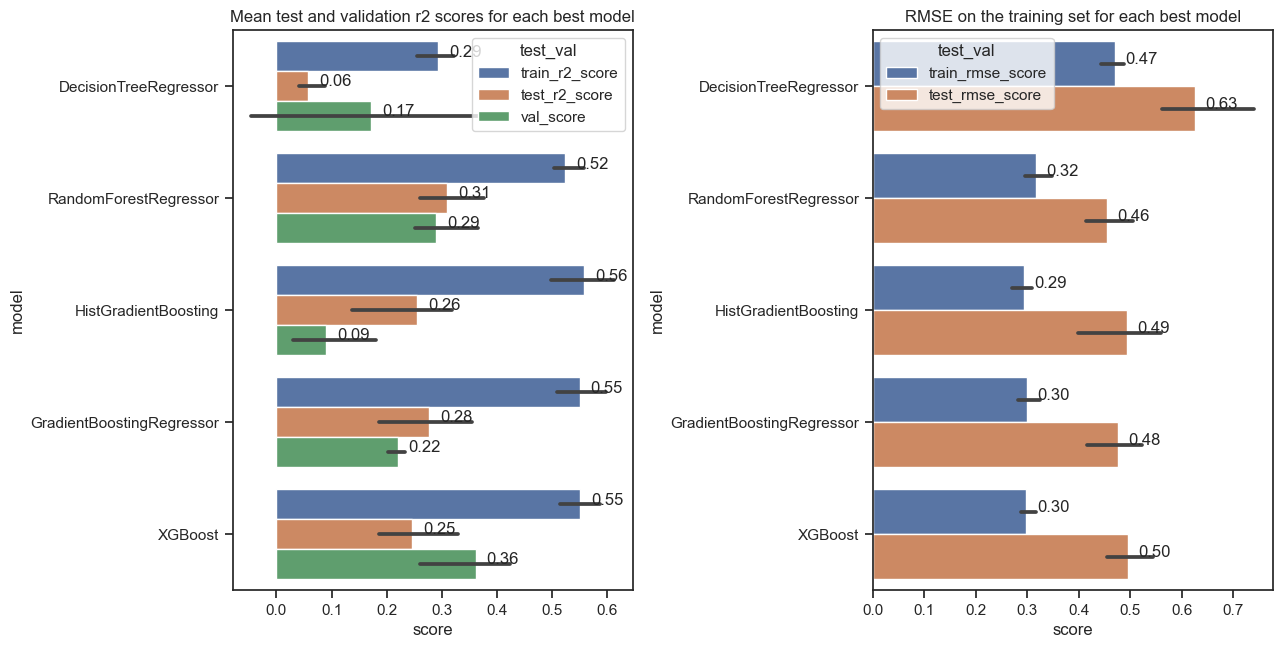

In [43]:
sns.set_theme(style="ticks")

sns.color_palette(palette='CMRmap')
fig, ax = plt.subplots(1,2, figsize = (16,8))

for i, v in enumerate([['train_r2_score', 'test_r2_score', 'val_score'], ['train_rmse_score', 'test_rmse_score']]):
    p = sns.barplot(data=model_scores_long[model_scores_long['test_val'].isin(v)], 
                    y = 'model', 
                    x = 'score', 
                    hue = 'test_val',
                    #palette = 'dark',
                    ax = ax[i])
    show_values(p, 'h', space = 0.02)    #larger value for space
plt.subplots_adjust(left=0.05,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.8, 
                    wspace=0.6, 
                    hspace=0.6)
ax[0].set_title('Mean test and validation r2 scores for each best model') 
ax[1].set_title('RMSE on the training set for each best model') 

plt.show()

Random Forest, Gradient Boosting and XGBoost look most promising - next check out the actual vs predicted and residual plots to see better

## 5. Plot actual vs predicted 

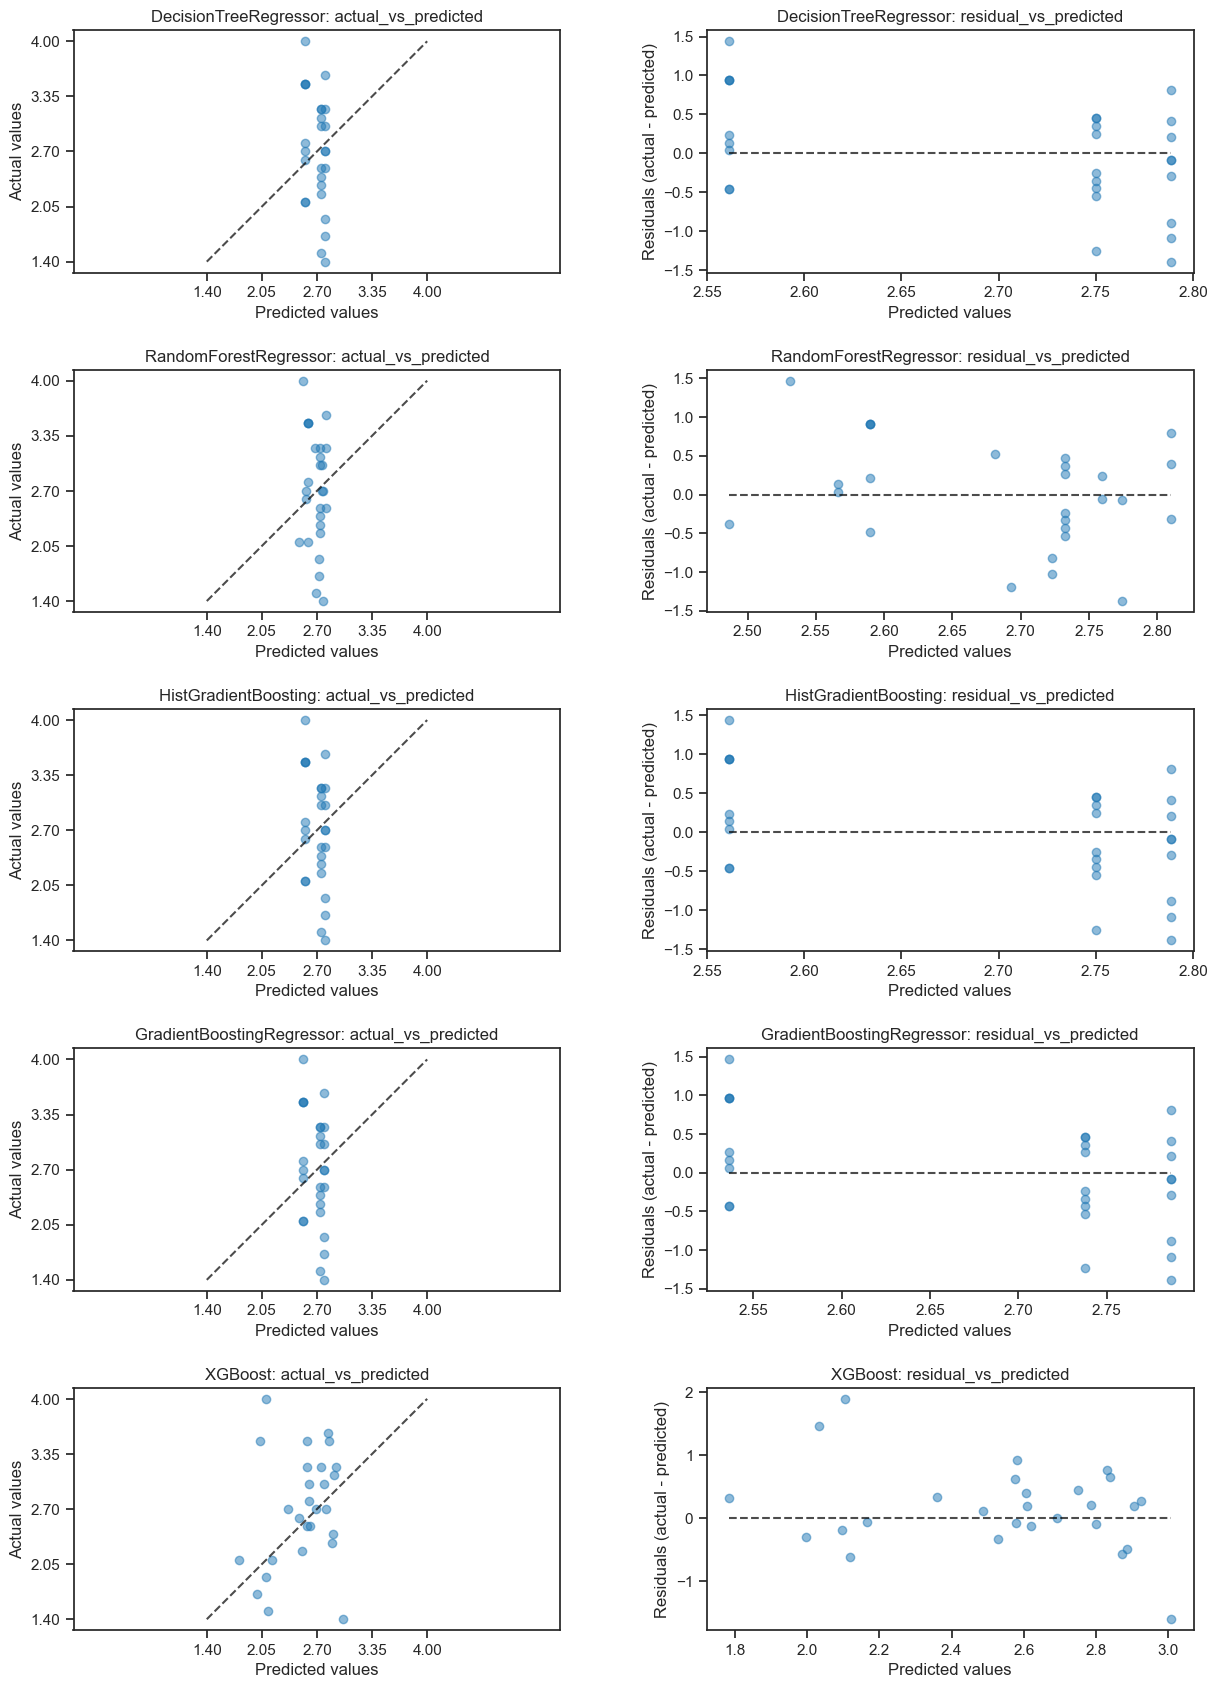

In [44]:
fig, axs= plt.subplots(5,2, figsize = (14, 20))

kind = ['actual_vs_predicted', 'residual_vs_predicted']

for n, m in enumerate(models.keys()):
    
    for i, k in enumerate(kind):
        y_pred_cv = cross_val_predict(
            best_models[n]['best_model'], 
            X_test, 
            y_test, 
            cv = 3
        )
        
        name = best_models[n]['model']
        
        PredictionErrorDisplay.from_predictions(
            y_test,
            y_pred_cv,
            kind = k,
            scatter_kwargs = {"alpha": 0.5},
            ax = axs[n][i]
        )
        axs[n][i].set_title(name +": " + k)
        
plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.3, 
                hspace=0.4)    
#plt.savefig('outputs/regressors_actualvspred.jpeg')    

#### XGBoost looks the best from scores above and the spread from these actual vs predicted plots

## 6. Plot feature importance of each best model

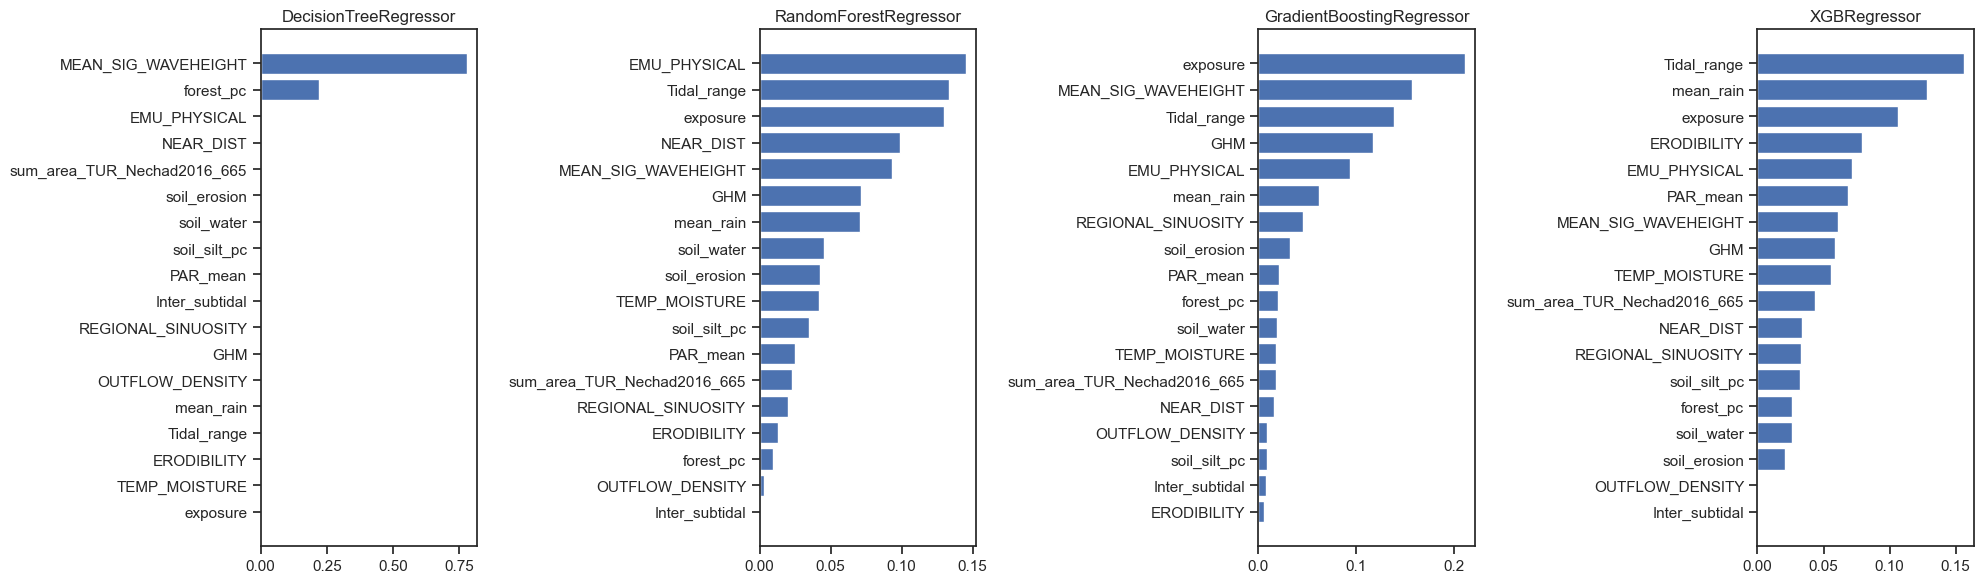

In [45]:
fig, ax = plt.subplots(1,4, figsize = (20,6))

#skips hist boost as doesn't have feature_importances_
a = range(0,4)
n = [0,1,3,4]
for n, a in zip(n, a):
    #print(n)
    bm = best_models[n]['best_model']
    #print(bm)
    feature_importances = bm.feature_importances_
    feature_importance_names = dict(zip(X_train.columns.tolist(), feature_importances))
    {k: v for k, v in sorted(feature_importance_names.items(), reverse = True, key=lambda item: item[1])}

    #plot feature importance for each model
    sorted_idx = np.argsort(feature_importances)
    pos = np.arange(sorted_idx.shape[0])+ .5

    #fig = plt.figure(figsize = (16,8))
    ax[a].barh(pos, feature_importances[sorted_idx], align = 'center', 
             #ax = ax[n]
            )
    ax[a].set_yticks(pos, np.array(X.columns)[sorted_idx])
    ax[a].set_title(str(bm).split('(')[0])
    
fig.tight_layout()
#plt.savefig('outputs/feature_importance_by_regressor.jpeg')
plt.show()

## 7. Plots to identify overfitting

XGBoost appears to be the best performing regressor. So the best hyperparameters for XGBoost are taken and one hyperparameter varied for each plot to see how the test and train scores vary using .predict(). This doesn't use CV. 

Please excuse the awful long winded code - my head hurt by this point and it was quicker to copy and paste than work out the loop!!

In [46]:
params = {'colsample_bytree': 0.3,
  'gamma': 0.1,
  'learning_rate': 0.1,
  'max_depth': 2,
  'min_child_weight': 0,
  'n_estimators': 32,
  'reg_lambda': 0.15}

In [47]:
#Working for one hyper param

md_train_r2scores, md_test_r2scores = list(), list()
md_train_msescores, md_test_msescores = list(), list()
md_values = [i for i in range(1,18)]

est_train_r2scores, est_test_r2scores = list(), list()
est_train_msescores, est_test_msescores = list(), list()
est_values = [i for i in range(20,210,20)]

ss_train_r2scores, ss_test_r2scores = list(), list()
ss_train_msescores, ss_test_msescores = list(), list()
ss_values = [i/10 for i in range(2,11,1)]

lr_train_r2scores, lr_test_r2scores = list(), list()
lr_train_msescores, lr_test_msescores = list(), list()
lr_values = [0.05]+[i/10 for i in range(1,10,1)]

cs_train_r2scores, cs_test_r2scores = list(), list()
cs_train_msescores, cs_test_msescores = list(), list()
cs_values = [i/10 for i in range(1,10,1)]

score = [r2_score, MSE]



#evaluate a xgboost decision tree for max depth
for i in md_values:
    for s in score:
        model = xgb.XGBRegressor(
            colsample_bytree= 0.4,
            learning_rate= 0.1,
            n_estimators= 32,
            subsample= 0.3,
            max_depth = i
        )
        model.fit(X_train, y_train)
        #evaluate on train dataset
        train_yhat = model.predict(X_train)
        test_yhat = model.predict(X_test)
        if s == r2_score:
            #calculate scores
            md_train_r2 = r2_score(y_train, train_yhat)
            md_train_r2scores.append(md_train_r2)
            md_test_r2 = r2_score(y_test, test_yhat)
            md_test_r2scores.append(md_test_r2)
        else:
            #calculate scores
            md_train_mse = MSE(y_train, train_yhat)**(1/2)
            md_train_msescores.append(md_train_mse)       
            md_test_mse = MSE(y_test, test_yhat)**(1/2)
            md_test_msescores.append(md_test_mse)

#evaluate a xgboost decision tree for n_estimators
for i in est_values:
    for s in score:
        model = xgb.XGBRegressor(n_estimators = i,
                                 colsample_bytree= 0.4,
                                 learning_rate= 0.1,
                                 max_depth= 2,
                                 subsample= 0.3)
        model.fit(X_train, y_train)
        #evaluate on train dataset
        train_yhat = model.predict(X_train)
        test_yhat = model.predict(X_test)
        if s == r2_score:
            #calculate scores
            est_train_r2 = r2_score(y_train, train_yhat)
            est_train_r2scores.append(est_train_r2)
            est_test_r2 = r2_score(y_test, test_yhat)
            est_test_r2scores.append(est_test_r2)
        else:
            #calculate scores
            est_train_mse = MSE(y_train, train_yhat)**(1/2)
            est_train_msescores.append(est_train_mse)       
            est_test_mse = MSE(y_test, test_yhat)**(1/2)
            est_test_msescores.append(est_test_mse)
    
#evaluate a xgboost decision tree for subsamples
for i in ss_values:
    for s in score:
        model = xgb.XGBRegressor(
            subsample = i,
            colsample_bytree= 0.4,
            learning_rate= 0.1,
            max_depth= 2,
            n_estimators= 32,
        )
        model.fit(X_train, y_train)
        #evaluate on train dataset
        train_yhat = model.predict(X_train)
        test_yhat = model.predict(X_test)
        if s == r2_score:
            #calculate scores
            ss_train_r2 = r2_score(y_train, train_yhat)
            ss_train_r2scores.append(ss_train_r2)
            ss_test_r2 = r2_score(y_test, test_yhat)
            ss_test_r2scores.append(ss_test_r2)
        else:
            #calculate scores
            ss_train_mse = MSE(y_train, train_yhat)**(1/2)
            ss_train_msescores.append(ss_train_mse)       
            ss_test_mse = MSE(y_test, test_yhat)**(1/2)
            ss_test_msescores.append(ss_test_mse)

#evaluate a xgboost decision tree for learning_rates
for i in lr_values:
    for s in score:
        model = xgb.XGBRegressor(
            learning_rate = i,
            colsample_bytree= 0.4,
            max_depth= 2,
            n_estimators= 32,
            subsample= 0.3
        )
        model.fit(X_train, y_train)
        #evaluate on train dataset
        train_yhat = model.predict(X_train)
        test_yhat = model.predict(X_test)
        if s == r2_score:
            #calculate scores
            lr_train_r2 = r2_score(y_train, train_yhat)
            lr_train_r2scores.append(lr_train_r2)
            lr_test_r2 = r2_score(y_test, test_yhat)
            lr_test_r2scores.append(lr_test_r2)
        else:
            #calculate scores
            lr_train_mse = MSE(y_train, train_yhat)**(1/2)
            lr_train_msescores.append(lr_train_mse)       
            lr_test_mse = MSE(y_test, test_yhat)**(1/2)
            lr_test_msescores.append(lr_test_mse)

#evaluate a xgboost decision tree for colsample_bytree
for i in cs_values:
    for s in score:
        model = xgb.XGBRegressor(
            colsample_bytree = i,
            learning_rate= 0.1,
            max_depth= 2,
            n_estimators= 32,
            subsample= 0.3
        )
        model.fit(X_train, y_train)
        #evaluate on train dataset
        train_yhat = model.predict(X_train)
        test_yhat = model.predict(X_test)
        if s == r2_score:
            #calculate scores
            cs_train_r2 = r2_score(y_train, train_yhat)
            cs_train_r2scores.append(cs_train_r2)
            cs_test_r2 = r2_score(y_test, test_yhat)
            cs_test_r2scores.append(cs_test_r2)
        else:
            #calculate scores
            cs_train_mse = MSE(y_train, train_yhat)**(1/2)
            cs_train_msescores.append(cs_train_mse)       
            cs_test_mse = MSE(y_test, test_yhat)**(1/2)
            cs_test_msescores.append(cs_test_mse)

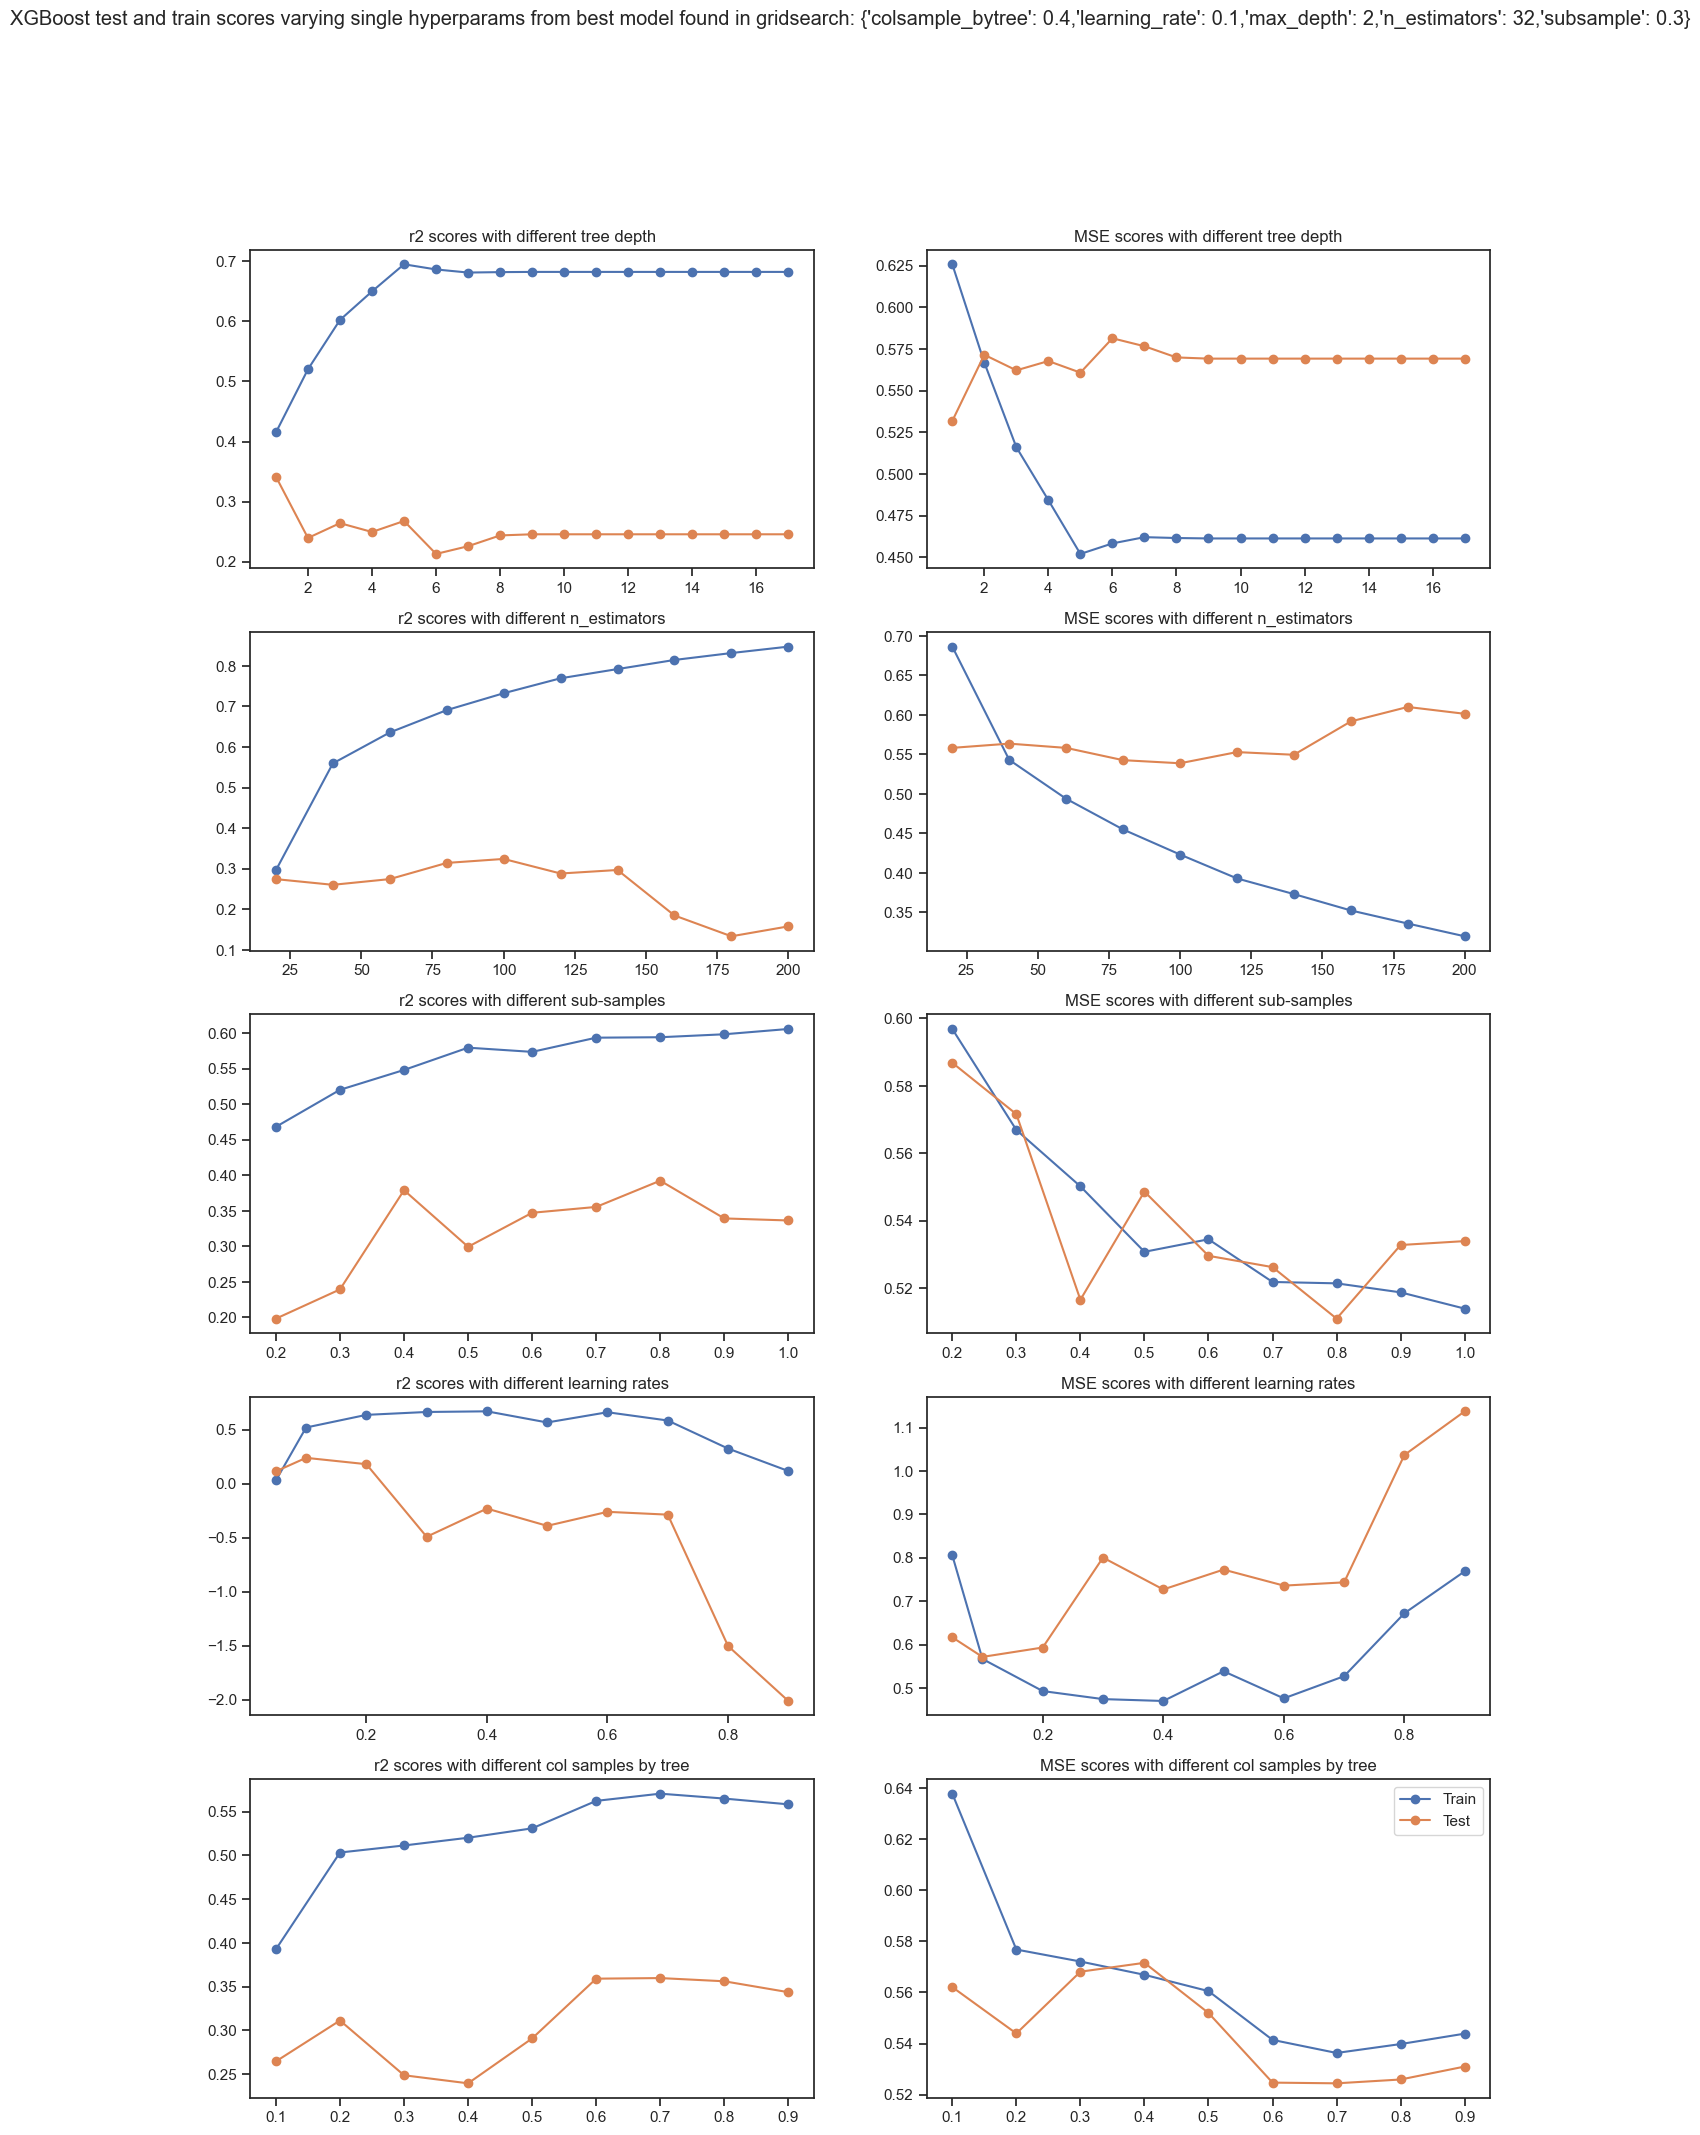

In [48]:
fig, ax = plt.subplots(5,2, figsize = (16,24))

#plot
ax[0][0].plot(md_values, md_train_r2scores, '-o', label = 'Train')
ax[0][0].plot(md_values, md_test_r2scores, '-o', label = 'Test')
ax[0][0].set_title('r2 scores with different tree depth')

ax[0][1].plot(md_values, md_train_msescores, '-o', label = 'Train')
ax[0][1].plot(md_values, md_test_msescores, '-o', label = 'Test')
ax[0][1].set_title('MSE scores with different tree depth')
#plt.legend()

#plot
ax[1][0].plot(est_values, est_train_r2scores, '-o', label = 'Train')
ax[1][0].plot(est_values, est_test_r2scores, '-o', label = 'Test')
ax[1][0].set_title('r2 scores with different n_estimators')

ax[1][1].plot(est_values, est_train_msescores, '-o', label = 'Train')
ax[1][1].plot(est_values, est_test_msescores, '-o', label = 'Test')
ax[1][1].set_title('MSE scores with different n_estimators')
#plt.legend()

#plot
ax[2][0].plot(ss_values, ss_train_r2scores, '-o', label = 'Train')
ax[2][0].plot(ss_values, ss_test_r2scores, '-o', label = 'Test')
ax[2][0].set_title('r2 scores with different sub-samples')

ax[2][1].plot(ss_values, ss_train_msescores, '-o', label = 'Train')
ax[2][1].plot(ss_values, ss_test_msescores, '-o', label = 'Test')
ax[2][1].set_title('MSE scores with different sub-samples')
#plt.legend()


#plot
ax[3][0].plot(lr_values, lr_train_r2scores, '-o', label = 'Train')
ax[3][0].plot(lr_values, lr_test_r2scores, '-o', label = 'Test')
ax[3][0].set_title('r2 scores with different learning rates')

ax[3][1].plot(lr_values, lr_train_msescores, '-o', label = 'Train')
ax[3][1].plot(lr_values, lr_test_msescores, '-o', label = 'Test')
ax[3][1].set_title('MSE scores with different learning rates')
#plt.legend()

#plot
ax[4][0].plot(cs_values, cs_train_r2scores, '-o', label = 'Train')
ax[4][0].plot(cs_values, cs_test_r2scores, '-o', label = 'Test')
ax[4][0].set_title('r2 scores with different col samples by tree')

ax[4][1].plot(cs_values, cs_train_msescores, '-o', label = 'Train')
ax[4][1].plot(cs_values, cs_test_msescores, '-o', label = 'Test')
ax[4][1].set_title('MSE scores with different col samples by tree')
plt.legend()

fig.suptitle("XGBoost test and train scores varying single hyperparams from best model found in gridsearch: {'colsample_bytree': 0.4,'learning_rate': 0.1,'max_depth': 2,'n_estimators': 32,'subsample': 0.3}")
#plt.savefig('outputs/test_train_scores_comparison.jpeg')
plt.show()

From these plots the best hyperparameters are already being used so can't see how to reduce overfitting further by tweaking hyperparameters

## 8. One-way Partial dependence Plots

Partial dependence plots are created for the XGBoost model for the top six features (continuous variables only) 

To show the dependence between the target response and a set of input features of interest, marginalising over the values of all other input features. We can interpret the partial dependence as the expected target response as a function of the input features of interest. e.g. the effect of exposure on carbon is higher exposure, lower carbon. 

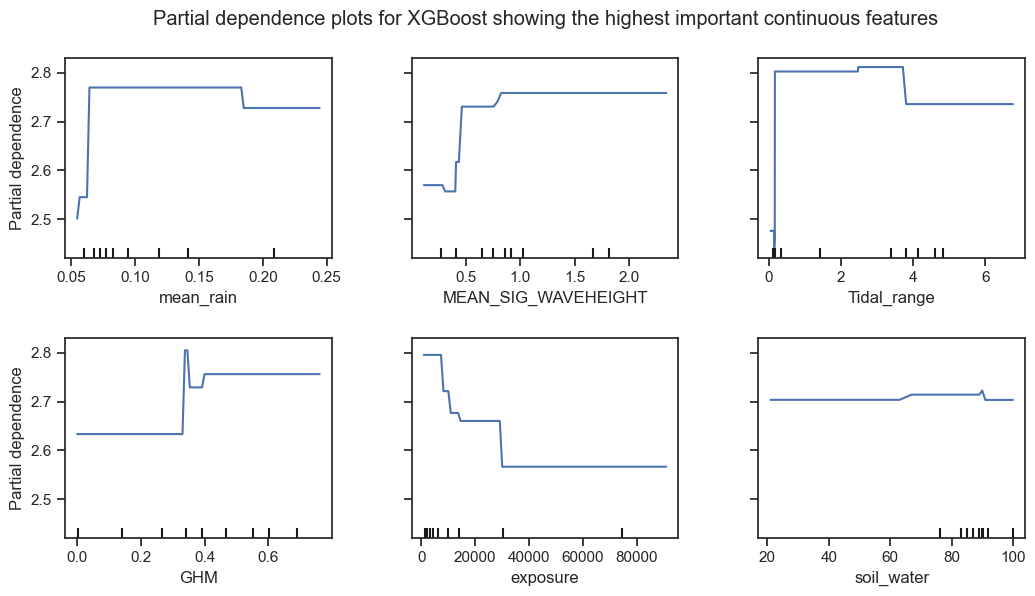

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))
#ax.set_title("XGBoost")
xgb_disp = PartialDependenceDisplay.from_estimator(
    best_models[4]['best_model'], 
    X_train, ['mean_rain', 'MEAN_SIG_WAVEHEIGHT', 'Tidal_range', 'GHM', "exposure", 'soil_water'], 
    ax=ax
)
fig.suptitle('Partial dependence plots for XGBoost showing the highest important continuous features')
plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.3, 
                hspace=0.4)    
plt.show()

In [77]:
#xgb.to_graphviz(best_models[4]['best_model'], num_trees = 2)